In [ ]:
!pip install ta
! pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.6/527.6 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.7/295.7 kB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 54.7 MB/s eta 0:00:00



--- Running Backtest for Interval: 1m ---
Note: Using max period '7d' for 1m interval.
Fetching data for BTC-USD (1m interval, 7d period)...
Data fetched successfully. Shape: (8767, 7)
Preparing data...
Data cleaned. Shape after cleaning: (8767, 5)
Test period defined. Starts at: 2025-04-22 23:37:00, Ends at: 2025-04-24 05:52:00
Calculating SMAs (Fast: 10 bars, Slow: 30 bars)...
Preparing data for vectorbt backtest...

Number of Entry Signals in Test Period: 33

Running vectorbt backtest with Stop-Loss and Take-Profit...
Stop-Loss: 1.00%
Take-Profit: 2.00%
Using vectorbt freq: '1T'

--- Backtest Results (1m Interval, SMA 10/30 with SL/TP) ---
Start                         2025-04-22 23:37:00
End                           2025-04-24 05:52:00
Period                            1 days 05:14:00
Start Value                                 100.0
End Value                               98.499441
Total Return [%]                        -1.500559
Benchmark Return [%]                    -1.01693

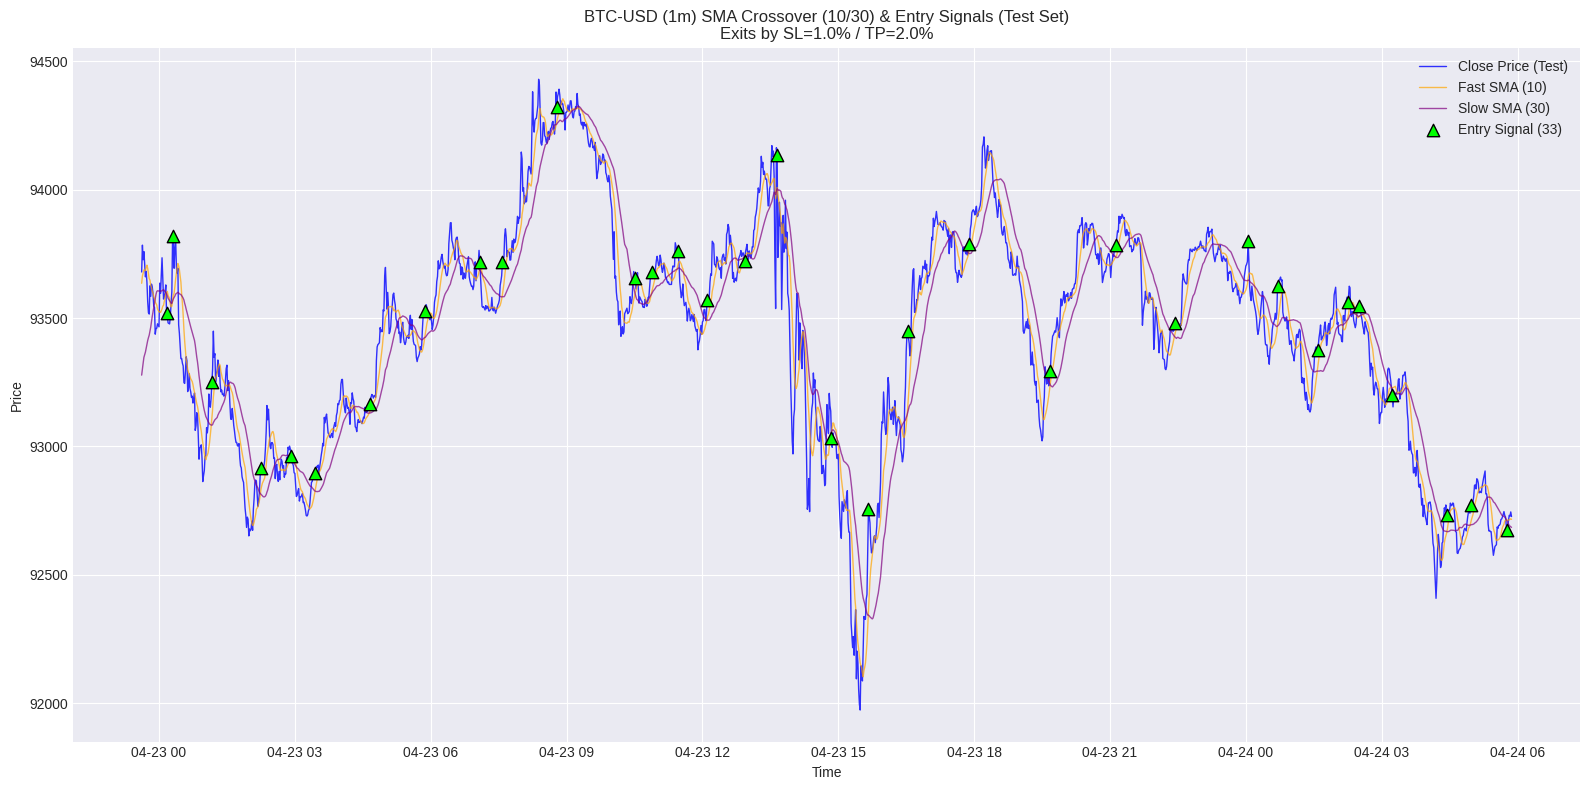


--- Running Backtest for Interval: 2m ---
Fetching data for BTC-USD (2m interval, 60d period)...
Data fetched successfully. Shape: (23393, 7)
Preparing data...
Data cleaned. Shape after cleaning: (23393, 5)
Test period defined. Starts at: 2025-04-17 17:54:00, Ends at: 2025-04-24 05:52:00
Calculating SMAs (Fast: 10 bars, Slow: 30 bars)...
Preparing data for vectorbt backtest...

Number of Entry Signals in Test Period: 90

Running vectorbt backtest with Stop-Loss and Take-Profit...
Stop-Loss: 1.00%
Take-Profit: 2.00%
Using vectorbt freq: '2T'

--- Backtest Results (2m Interval, SMA 10/30 with SL/TP) ---
Start                         2025-04-17 17:54:00
End                           2025-04-24 05:52:00
Period                            6 days 11:58:00
Start Value                                 100.0
End Value                              101.375751
Total Return [%]                         1.375751
Benchmark Return [%]                     8.859467
Max Gross Exposure [%]                  

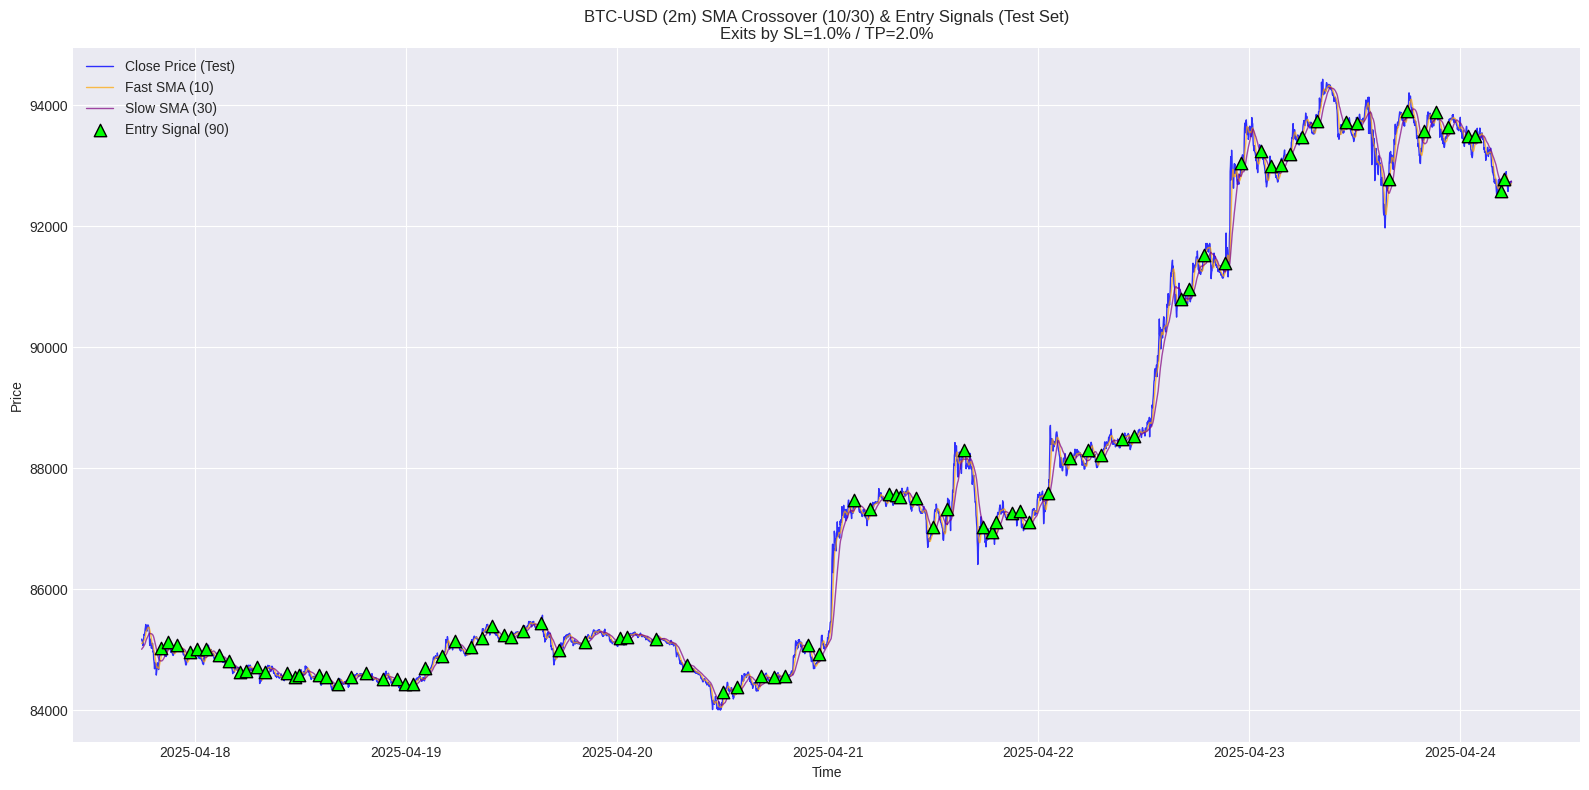


--- Running Backtest for Interval: 5m ---
Fetching data for BTC-USD (5m interval, 60d period)...
Data fetched successfully. Shape: (17063, 7)
Preparing data...
Data cleaned. Shape after cleaning: (17063, 5)
Test period defined. Starts at: 2025-04-12 09:30:00, Ends at: 2025-04-24 05:50:00
Calculating SMAs (Fast: 10 bars, Slow: 30 bars)...
Preparing data for vectorbt backtest...

Number of Entry Signals in Test Period: 65

Running vectorbt backtest with Stop-Loss and Take-Profit...
Stop-Loss: 1.00%
Take-Profit: 2.00%
Using vectorbt freq: '5T'

--- Backtest Results (5m Interval, SMA 10/30 with SL/TP) ---
Start                               2025-04-12 09:30:00
End                                 2025-04-24 05:50:00
Period                                 11 days 20:25:00
Start Value                                       100.0
End Value                                    105.182447
Total Return [%]                               5.182447
Benchmark Return [%]                          11.15505

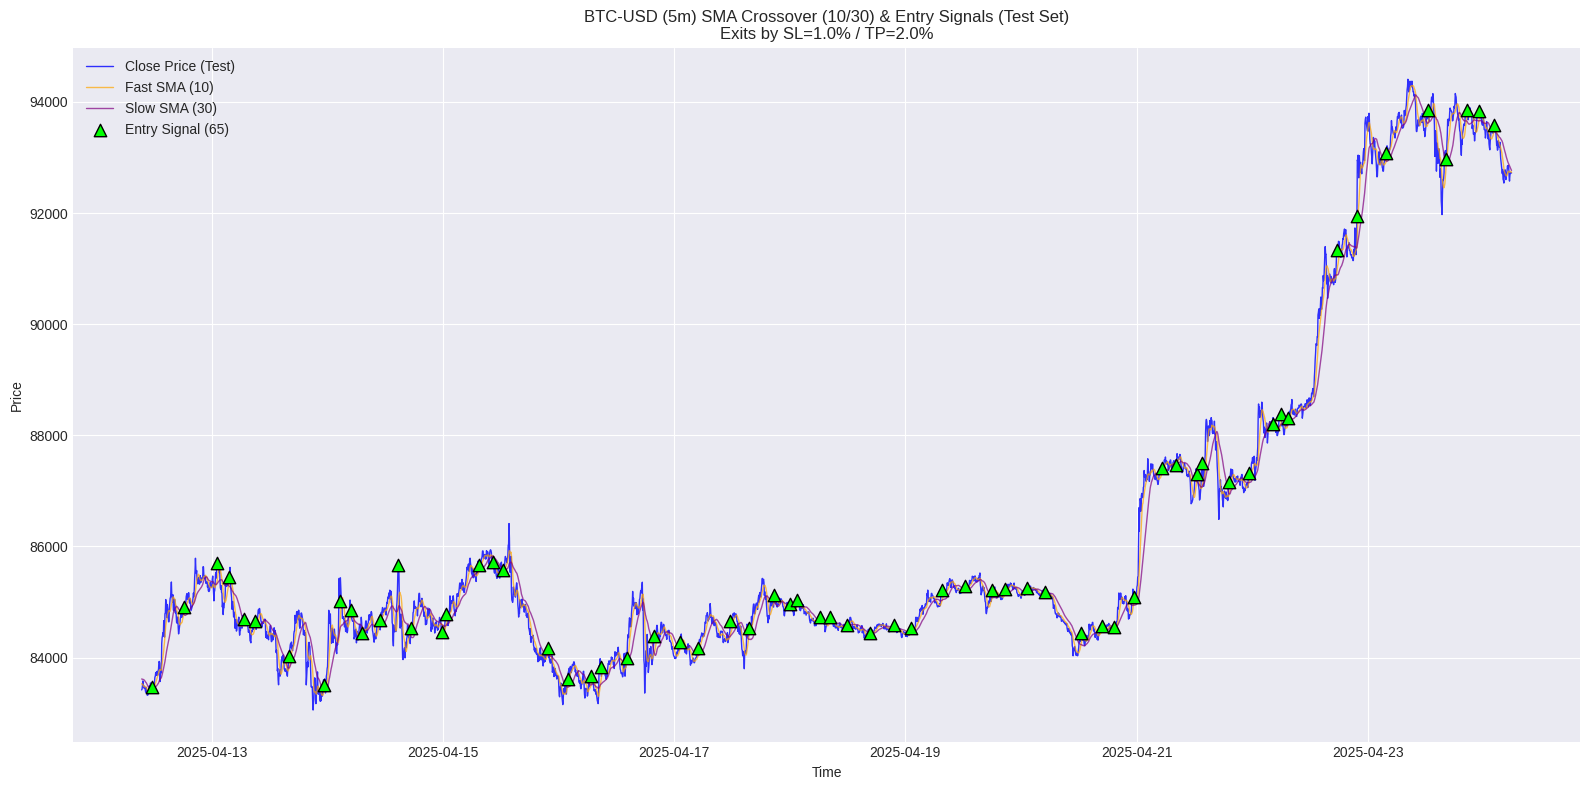


--- All Backtests Complete ---


In [ ]:
# %%writefile sma_crossover_btc_sl_tp_multi_interval.py
import yfinance as yf
import pandas as pd
import numpy as np
import ta # Technical Analysis library
import matplotlib.pyplot as plt
import vectorbt as vbt
import warnings

# Suppress specific warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

# --- Global Configuration ---
TICKER = 'BTC-USD'
TEST_SIZE = 0.2 # Defines portion of data used for backtesting

# --- Strategy & Backtesting Parameters ---
# These can be adjusted, potentially based on interval inside the function if needed
FAST_SMA_WINDOW = 10 # Number of bars for fast SMA
SLOW_SMA_WINDOW = 30 # Number of bars for slow SMA
SL_PERCENT = 0.010   # Stop Loss at 1.0% below entry price
TP_PERCENT = 0.020   # Take Profit at 2.0% above entry price
INIT_CASH = 100
FEE = 0.001          # 0.1% fee per trade
SLIPPAGE = 0.0005    # 0.05% slippage per trade

def run_sma_backtest(interval: str):
    """
    Fetches data, runs SMA crossover backtest with SL/TP, and plots results
    for a given interval.
    """
    print(f"\n--- Running Backtest for Interval: {interval} ---")

    # --- Adjust Period based on yfinance limits ---
    if interval == '1m':
        period = '7d' # Max allowed for 1m
        vbt_freq = '1T'
        print(f"Note: Using max period '{period}' for 1m interval.")
    elif interval == '2m':
        period = '60d' # Allowed for 2m
        vbt_freq = '2T'
    elif interval == '5m':
        period = '60d' # Allowed for 5m
        vbt_freq = '5T'
    # Add other intervals here if needed (e.g., 15m, 30m, 1h)
    # elif interval == '1h':
    #    period = '730d' # Allowed for 1h
    #    vbt_freq = '1H'
    else:
        print(f"Error: Interval '{interval}' not explicitly handled for period/freq setting.")
        return

    # --- 1. Data Acquisition ---
    print(f"Fetching data for {TICKER} ({interval} interval, {period} period)...")
    try:
        stock_data = yf.Ticker(TICKER).history(period=period, interval=interval, auto_adjust=True)
        if stock_data.empty:
            raise ValueError(f"No data found for {TICKER} with interval {interval} and period {period}.")
        stock_data.columns = [col.lower() for col in stock_data.columns]
        if stock_data.index.tz is not None:
            stock_data.index = stock_data.index.tz_localize(None)
        print(f"Data fetched successfully. Shape: {stock_data.shape}")
        # print(stock_data.head()) # Optional: print head
    except Exception as e:
        print(f"Error fetching data: {e}")
        return # Stop execution for this interval if data fails

    # --- 2. Feature Engineering (Minimal - only need close for SMA) ---
    print("Preparing data...")
    features_df = stock_data[['open', 'high', 'low', 'close', 'volume']].copy()

    # --- Data Cleaning ---
    features_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    initial_rows = len(features_df)
    features_df.dropna(inplace=True)
    rows_dropped = initial_rows - len(features_df)
    if rows_dropped > 0:
        print(f"Dropped {rows_dropped} rows with NaNs in OHLCV data.")
    if features_df.empty:
        print("Error: No data remaining after cleaning OHLCV.")
        return
    print(f"Data cleaned. Shape after cleaning: {features_df.shape}")

    # --- Define Test Period Indices ---
    split_idx_data = int(len(features_df) * (1 - TEST_SIZE))
    if split_idx_data == 0 or split_idx_data >= len(features_df) -1:
         print(f"Error: TEST_SIZE ({TEST_SIZE}) results in invalid split for data length {len(features_df)}.")
         return
    test_indices_full = features_df.index[split_idx_data:]
    if test_indices_full.empty:
        print("Error: Test period is empty based on TEST_SIZE.")
        return
    print(f"Test period defined. Starts at: {test_indices_full[0]}, Ends at: {test_indices_full[-1]}")

    # --- Calculate SMAs ---
    # Note: Window size means number of BARS. Duration depends on interval.
    # 10/30 bars on 1m = 10min/30min. On 5m = 50min/150min.
    print(f"Calculating SMAs (Fast: {FAST_SMA_WINDOW} bars, Slow: {SLOW_SMA_WINDOW} bars)...")
    close_prices = features_df['close']
    fast_sma = ta.trend.sma_indicator(close_prices, window=FAST_SMA_WINDOW)
    slow_sma = ta.trend.sma_indicator(close_prices, window=SLOW_SMA_WINDOW)

    # --- Generate SMA Crossover Signals ---
    entries = vbt.MA.run(close_prices, FAST_SMA_WINDOW).ma_crossed_above(vbt.MA.run(close_prices, SLOW_SMA_WINDOW))

    # --- Prepare Data for Backtest ---
    print("Preparing data for vectorbt backtest...")
    try:
        # Select signals and prices within the test period
        entries_test = entries.loc[test_indices_full].fillna(False)
        price_data_test = close_prices.loc[entries_test.index] # Align price to signals index
        # Align SMAs for plotting later (use price_data_test.index for consistency)
        fast_sma_test = fast_sma.loc[price_data_test.index]
        slow_sma_test = slow_sma.loc[price_data_test.index]

    except KeyError as e:
         print(f"Error aligning data/signals to test period index: {e}")
         print("This might happen if test_indices_full contains values not in the original signals/SMA series (e.g., due to NaNs at start).")
         # Attempt recovery: reindex signals/SMAs first? Or just skip? Let's skip for now.
         return

    # --- Sanity Checks ---
    print(f"\nNumber of Entry Signals in Test Period: {entries_test.sum()}")
    if entries_test.sum() == 0:
        print("Warning: No SMA crossover entry signals generated in the test period.")
    if price_data_test.empty or len(price_data_test) != len(entries_test):
        print("Error: Price data mismatch with entry signals AFTER alignment for test period.")
        return
    if not price_data_test.index.equals(entries_test.index):
        print("Error: Price data index does not match entry signal index AFTER alignment.")
        return

    # --- Run Vectorbt Backtest with SL/TP ---
    print("\nRunning vectorbt backtest with Stop-Loss and Take-Profit...")
    print(f"Stop-Loss: {SL_PERCENT*100:.2f}%")
    print(f"Take-Profit: {TP_PERCENT*100:.2f}%")
    print(f"Using vectorbt freq: '{vbt_freq}'")

    if entries_test.sum() > 0:
        portfolio = vbt.Portfolio.from_signals(
            close=price_data_test,
            entries=entries_test,
            freq=vbt_freq, # Use interval-specific frequency
            init_cash=INIT_CASH,
            fees=FEE,
            slippage=SLIPPAGE,
            sl_stop=SL_PERCENT,
            tp_stop=TP_PERCENT,
        )

        # --- Analyze Backtest Results ---
        print(f"\n--- Backtest Results ({interval} Interval, SMA {FAST_SMA_WINDOW}/{SLOW_SMA_WINDOW} with SL/TP) ---")
        stats = portfolio.stats()
        print(stats)

        # Optional: Analyze trades hitting SL vs TP
        # if portfolio.trades.count() > 0 and not portfolio.trades.records.empty:
        #    sl_hits = portfolio.trades.records[portfolio.trades.records['Stop Type'] == 'StopLoss'].shape[0]
        #    tp_hits = portfolio.trades.records[portfolio.trades.records['Stop Type'] == 'TakeProfit'].shape[0]
        #    print(f"\nTrades closed by Stop Loss: {sl_hits}")
        #    print(f"Trades closed by Take Profit: {tp_hits}")
        #    other_closes = portfolio.trades.count() - sl_hits - tp_hits
        #    if other_closes > 0:
        #         print(f"Other Closes (e.g., end of data): {other_closes}")

        # --- Plotting ---
        print("\nGenerating plots...")
        try:
            plt.style.use('seaborn-v0_8-darkgrid')

            # 1. Price vs SMAs Plot with Entry Signals
            plt.figure(figsize=(16, 8))
            plot_indices = price_data_test.index
            plt.plot(plot_indices, price_data_test.values, label='Close Price (Test)', alpha=0.8, linewidth=1.0, color='blue')
            plt.plot(plot_indices, fast_sma_test.values, label=f'Fast SMA ({FAST_SMA_WINDOW})', alpha=0.7, linewidth=1.0, color='orange')
            plt.plot(plot_indices, slow_sma_test.values, label=f'Slow SMA ({SLOW_SMA_WINDOW})', alpha=0.7, linewidth=1.0, color='purple')

            entry_points = price_data_test[entries_test] # Get prices where entries are True
            plt.scatter(entry_points.index, entry_points.values, marker='^', color='lime', label=f'Entry Signal ({entries_test.sum()})', s=80, alpha=1.0, edgecolors='black', zorder=5)

            plt.title(f'{TICKER} ({interval}) SMA Crossover ({FAST_SMA_WINDOW}/{SLOW_SMA_WINDOW}) & Entry Signals (Test Set)\nExits by SL={SL_PERCENT*100:.1f}% / TP={TP_PERCENT*100:.1f}%')
            plt.xlabel('Time')
            plt.ylabel('Price')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

            # 2. Vectorbt Portfolio Plot
            fig = portfolio.plot(settings=dict(plot_cash=True))
            fig.update_layout(title=f'{TICKER} SMA Crossover ({interval}) Backtest Performance with SL/TP')
            fig.show()

        except Exception as e:
            print(f"Could not generate plots: {e}")

    else:
        print("\nSkipping backtest analysis and plotting as no entry signals were generated.")
        # Optionally plot price and SMAs anyway
        plt.figure(figsize=(16, 8))
        plot_indices = price_data_test.index
        if not price_data_test.empty and not fast_sma_test.empty and not slow_sma_test.empty:
            plt.plot(plot_indices, price_data_test.values, label='Close Price (Test)', alpha=0.8, linewidth=1.0, color='blue')
            plt.plot(plot_indices, fast_sma_test.values, label=f'Fast SMA ({FAST_SMA_WINDOW})', alpha=0.7, linewidth=1.0, color='orange')
            plt.plot(plot_indices, slow_sma_test.values, label=f'Slow SMA ({SLOW_SMA_WINDOW})', alpha=0.7, linewidth=1.0, color='purple')
            plt.title(f'{TICKER} ({interval}) Price & SMAs (Test Set) - No Crossover Entries')
            plt.xlabel('Time')
            plt.ylabel('Price')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()
        else:
            print("Could not generate diagnostic plot - data missing or empty.")

# --- Run Backtests for Different Intervals ---
if __name__ == "__main__":
    run_sma_backtest(interval='1m')
    run_sma_backtest(interval='2m')
    run_sma_backtest(interval='5m')
    # run_sma_backtest(interval='5m') # Optional: Run the 5m version for comparison
    print("\n--- All Backtests Complete ---")